# **Dataset 5**

### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from Data_Generation.data_synthesizer import ds_generate_data
from Data_Generation.synthetic_data_vault import sdv_generate_data
from Data_Evaluation.utility import run_utility_eval
from Data_Evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from Data_Evaluation.privacy import dcr, nndr, mia

### **Exploratory Data Analysis**

In [2]:
data_path = "Original_Data/Dataset_5/Dataset_5.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [4]:
original_data.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [5]:
original_data.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
dtype: int64

In [6]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

school ['GP' 'MS']
sex ['F' 'M']
address ['U' 'R']
famsize ['GT3' 'LE3']
Pstatus ['A' 'T']
Mjob ['at_home' 'health' 'other' 'services' 'teacher']
Fjob ['teacher' 'other' 'services' 'health' 'at_home']
reason ['course' 'other' 'home' 'reputation']
guardian ['mother' 'father' 'other']
schoolsup ['yes' 'no']
famsup ['no' 'yes']
paid ['no' 'yes']
activities ['no' 'yes']
nursery ['yes' 'no']
higher ['yes' 'no']
internet ['no' 'yes']
romantic ['no' 'yes']


<Axes: xlabel='G3', ylabel='Count'>

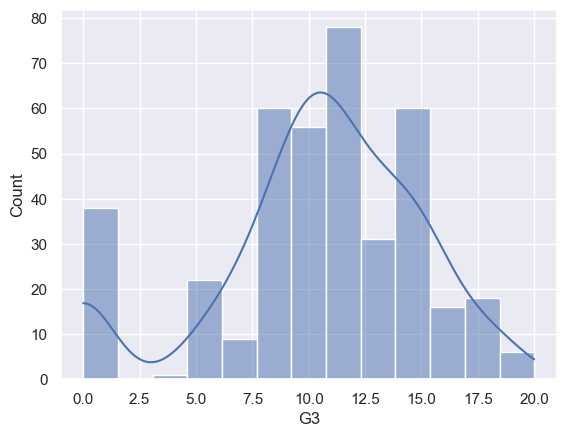

In [7]:
# Check class distribution
sns.histplot(original_data['G3'], kde=True)

### **Synthetic Data Generation**

In [8]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
train_data.to_csv("Original_Data/Dataset_5/train_data.csv", index=False)
test_data.to_csv("Original_Data/Dataset_5/test_data.csv", index=False)

In [9]:
import os

synthetic_data_folder = "Synthetic_Data/Dataset_5/"
csv_files = [file for file in os.listdir(synthetic_data_folder) if file.endswith(".csv")]

if len(csv_files) == 0:

    # Use train_data.csv to fit SDG models and generate synthetic data

    data_path = "Original_Data/Dataset_5/train_data.csv"
    arguments = [data_path, str(n), "5"]

    print("Sampling synthpop...")
    result = subprocess.run(['Rscript', 'Data_Generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("Sampling DataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_nr="5")

    sdv_generate_data(data_path=data_path, num_samples=n, dataset_nr="5")

Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [10]:
synthpop = pd.read_csv("Synthetic_Data/Dataset_5/synthpop_samples.csv")
ds = pd.read_csv("Synthetic_Data/Dataset_5/ds_samples.csv")
tvae = pd.read_csv("Synthetic_Data/Dataset_5/tvae_samples.csv")
gaussian_copula = pd.read_csv("Synthetic_Data/Dataset_5/gaussian_samples.csv")
copula_gan = pd.read_csv("Synthetic_Data/Dataset_5/copula_gan_samples.csv")
ctgan = pd.read_csv("Synthetic_Data/Dataset_5/ctgan_samples.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le


In [11]:
ctgan.head(20)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,1,17,1,0,1,1,4,2,2,...,1,4,4,1,1,5,6,8,15,6
1,0,0,18,1,0,1,2,2,4,2,...,4,2,4,2,1,1,1,12,11,13
2,0,1,17,1,0,1,2,3,0,2,...,4,4,3,1,3,5,2,18,19,0
3,0,1,17,1,1,1,3,2,3,2,...,4,2,3,1,2,3,28,12,8,0
4,0,1,18,0,0,1,4,2,1,2,...,2,2,4,2,1,5,6,9,16,14
5,0,1,16,1,1,1,3,2,4,0,...,4,3,2,2,1,5,3,19,14,7
6,0,0,19,1,0,1,3,4,0,2,...,5,4,2,1,1,5,24,11,19,13
7,0,0,16,0,0,1,2,2,4,2,...,3,1,2,2,1,5,75,16,13,7
8,0,1,17,1,0,1,3,1,1,2,...,5,5,3,1,4,4,2,6,3,16
9,0,0,16,0,0,1,2,4,1,2,...,4,3,2,1,1,5,29,12,14,10


### **Utility Evaluation**

Prepare utility evaluation

In [12]:
models = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]
target_col = "G3"

for model in models:
    model.drop(["G1", "G2"], axis=1, inplace=True)
    model[target_col] = pd.cut(model[target_col], bins=[-1, 7, 14, 20], labels=[0, 1, 2])

train_data.drop(["G1", "G2"], axis=1, inplace=True)
train_data[target_col] = pd.cut(train_data[target_col], bins=[-1, 7, 14, 20], labels=[0, 1, 2])
test_data.drop(["G1", "G2"], axis=1, inplace=True)
test_data[target_col] = pd.cut(test_data[target_col], bins=[-1, 7, 14, 20], labels=[0, 1, 2])

In [13]:
train_data["G3"].unique()

[1, 2, 0]
Categories (3, int64): [0 < 1 < 2]

Run random forest classifier for utility evaluation

In [14]:
rf_results = {}
rf_df = pd.read_csv("Evaluation_Results/RF_Results.csv")
rows = []

for i, model in enumerate(models):
    rf_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "random_forest")

    acc_diff = rf_results[model_names[i]]["acc_diff"]
    f1_diff = rf_results[model_names[i]]["f1_diff"]
    roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

    rows.append([5, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=rf_df.columns)
rf_df = pd.concat([rf_df, rows], ignore_index=True)
rf_df.to_csv("Evaluation_Results/RF_Results.csv", index=False)
rf_df.tail(20)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
4,1,copula_gan,0.42,0.44,0.40
5,1,ctgan,0.50,0.55,0.43
6,2,synthpop,-0.04,0.01,-0.05
7,2,ds,0.04,0.05,0.04
8,2,tvae,-0.03,-0.02,-0.03
9,2,gaussian_copula,-0.06,0.01,-0.04
10,2,copula_gan,-0.07,0.01,0.06
11,2,ctgan,0.43,0.50,0.02
12,3,synthpop,-0.09,-0.10,-0.03
13,3,ds,0.33,0.25,0.34


Run logistic regression for utility evaluation

In [15]:
lr_results = {}
lr_df = pd.read_csv("Evaluation_Results/LR_Results.csv")
rows = []

for i, model in enumerate(models):
    lr_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "logistic_regression")

    acc_diff = lr_results[model_names[i]]["acc_diff"]
    f1_diff = lr_results[model_names[i]]["f1_diff"]
    roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

    rows.append([5, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=lr_df.columns)
lr_df = pd.concat([lr_df, rows])
lr_df.to_csv("Evaluation_Results/LR_Results.csv", index=False)
lr_df.tail(7)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
17,3,ctgan,-0.08,0.00,-0.17
0,5,synthpop,0.09,0.17,0.04
1,5,ds,0.12,0.15,0.19
2,5,tvae,0.09,0.11,0.03
3,5,gaussian_copula,0.08,0.19,0.10
4,5,copula_gan,0.10,0.18,0.16
5,5,ctgan,0.23,0.21,0.25


Run multilayer perceptron (MLP)

In [16]:
mlp_results = {}
mlp_df = pd.read_csv("Evaluation_Results/MLP_Results.csv")
rows = []

for i, model in enumerate(models):
    mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "multilayer_perceptron")

    acc_diff = mlp_results[model_names[i]]["acc_diff"]
    f1_diff = mlp_results[model_names[i]]["f1_diff"]
    roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

    rows.append([5, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=mlp_df.columns)
mlp_df = pd.concat([mlp_df, rows])
mlp_df.to_csv("Evaluation_Results/MLP_Results.csv", index=False)
mlp_df.tail(7)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
17,3,ctgan,0.00,0.00,-0.11
0,5,synthpop,0.02,0.01,0.03
1,5,ds,0.25,0.18,0.19
2,5,tvae,0.05,0.07,0.05
3,5,gaussian_copula,0.07,0.13,0.13
4,5,copula_gan,0.09,0.05,0.10
5,5,ctgan,0.25,0.20,0.18


### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [17]:
corr_diff_df = pd.read_csv("Evaluation_Results/corr_diff.csv")
rows = []

for i, model in enumerate(models):
    result = pairwise_correlation_diff(train_data, model)
    rows.append([5,model_names[i], result])

rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
corr_diff_df = pd.concat([corr_diff_df, rows])
corr_diff_df.to_csv("Evaluation_Results/corr_diff.csv", index=False)
corr_diff_df.tail(7)

,Dataset,Model,Pairwise Corr Diff
17,3,ctgan,0.239476
0,5,synthpop,0.041834
1,5,ds,0.120281
2,5,tvae,0.093117
3,5,gaussian_copula,0.073272
4,5,copula_gan,0.082277
5,5,ctgan,0.081352


**Jensen-Shannon Divergence**

In [18]:
jsd_df = pd.read_csv("Evaluation_Results/jsd.csv")
rows = []

for i, model in enumerate(models):
    result = jsd(train_data, model)
    rows.append([5,model_names[i], result])

rows = pd.DataFrame(rows, columns=jsd_df.columns)
jsd_df = pd.concat([jsd_df, rows])
jsd_df.to_csv("Evaluation_Results/jsd.csv", index=False)
jsd_df.tail(7)

,Dataset,Model,JSD Diff
17,3,ctgan,0.143693
0,5,synthpop,0.000258
1,5,ds,0.089895
2,5,tvae,0.145517
3,5,gaussian_copula,0.004071
4,5,copula_gan,0.010652
5,5,ctgan,0.012078


**Wasserstein Distance**

In [19]:
wd_df = pd.read_csv("Evaluation_Results/wd.csv")
rows = []

for i, model in enumerate(models):
    result = wd(train_data, model)
    rows.append([5,model_names[i], result])

rows = pd.DataFrame(rows, columns=wd_df.columns)
wd_df = pd.concat([wd_df, rows])
wd_df.to_csv("Evaluation_Results/wd.csv", index=False)
wd_df.tail(7)

,Dataset,Model,WD Diff
17,3,ctgan,0.029097
0,5,synthpop,0.006696
1,5,ds,0.139344
2,5,tvae,0.234419
3,5,gaussian_copula,0.010031
4,5,copula_gan,0.050077
5,5,ctgan,0.045989


### **Privacy**

Run privacy evaluation using Distance to closest Record (DCR), Nearest Neighbour Difference Ratio (NNDR) and Membership Inference Attack (MIA)

- **DCR**: a value of zero indicates that the synthetic record is an identical copy of the original
one -> leak of real information, higher values indicate more privacy

- **NNDR**: ratio is within [0,1], higher values indicate better privacy

- **MIA**: both accuracy and precision should be below 0.5 for all thresholds for strong privacy preservation

**Distance to closest record (DCR)**

In [20]:
dcr_df = pd.read_csv("Evaluation_Results/dcr.csv")
rows = []

for i, model in enumerate(models):
    result = dcr(train_data, model, model_names[i], dataset_nr=5, save_hist=True)
    result_within_real = dcr(train_data, model, model_names[i], dataset_nr=5, within="Original", save_hist=True)
    result_within_synth = dcr(train_data, model, model_names[i], dataset_nr=5, within="Synthetic", save_hist=True)
    rows.append([5,model_names[i], result, result_within_real, result_within_synth])

rows = pd.DataFrame(rows, columns=dcr_df.columns)
dcr_df = pd.concat([dcr_df, rows])
dcr_df.to_csv("Evaluation_Results/dcr.csv", index=False)
dcr_df.tail(7)

,Dataset,Model,DCR 5th Percentile,DCR 5th Percentile (within Real),DCR 5th Percentile (within Synthetic)
17,3,ctgan,11.135,6.009,5.853
0,5,synthpop,2.828,3.000,2.000
1,5,ds,4.899,3.000,2.449
2,5,tvae,3.317,3.000,0.000
3,5,gaussian_copula,3.317,3.000,2.646
4,5,copula_gan,3.464,3.000,3.000
5,5,ctgan,3.464,3.000,2.828


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [21]:
nndr_df = pd.read_csv("Evaluation_Results/nndr.csv")
rows = []

for i, model in enumerate(models):
    result = nndr(train_data, model)
    result_within_real = nndr(train_data, model, within="Original")
    result_within_synth = nndr(train_data, model, within="Synthetic")
    rows.append([5,model_names[i], result, result_within_real, result_within_synth])

rows = pd.DataFrame(rows, columns=nndr_df.columns)
nndr_df = pd.concat([nndr_df, rows])
nndr_df.to_csv("Evaluation_Results/nndr.csv", index=False)
nndr_df.tail(7) 

,Dataset,Model,NNDR 5th percentile,NNDR 5th percentile (within Real),NNDR 5th percentile (within Synthetic)
17,3,ctgan,0.622,0.583,0.691
0,5,synthpop,0.750,0.775,0.745
1,5,ds,0.419,0.775,0.707
2,5,tvae,0.832,0.775,0.000
3,5,gaussian_copula,0.791,0.775,0.832
4,5,copula_gan,0.761,0.775,0.834
5,5,ctgan,0.768,0.775,0.832


**Membership Inference Attack (MIA)**

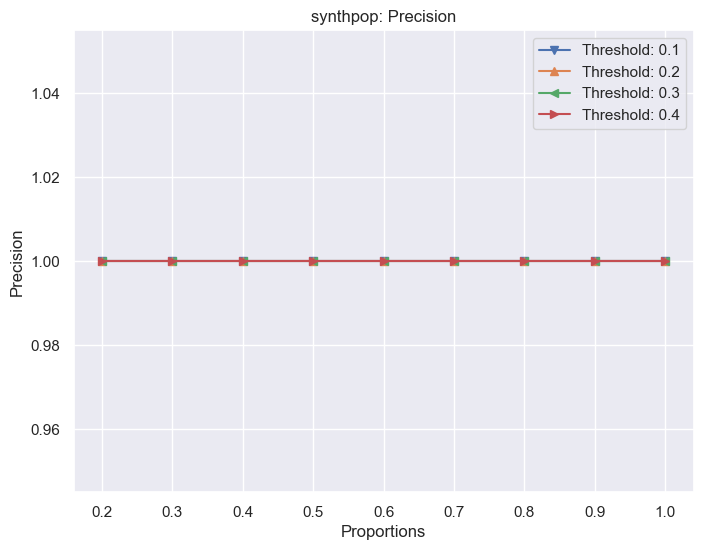

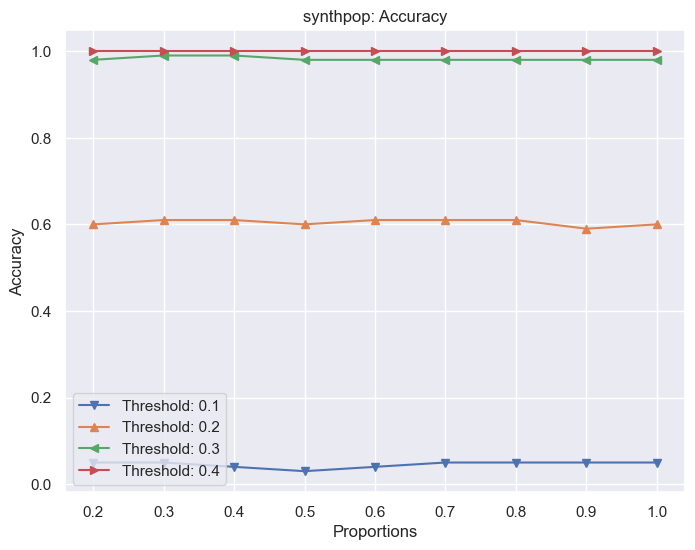

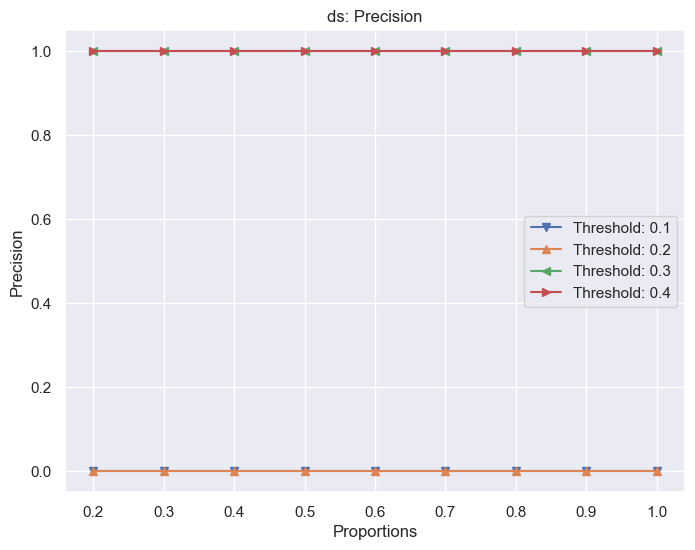

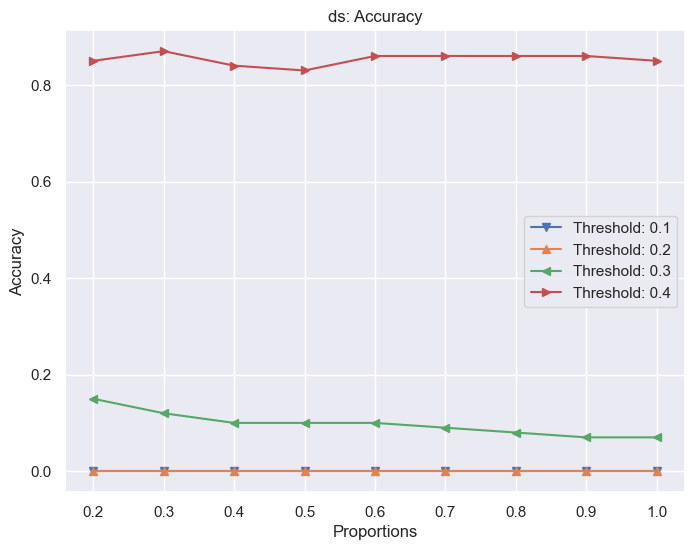

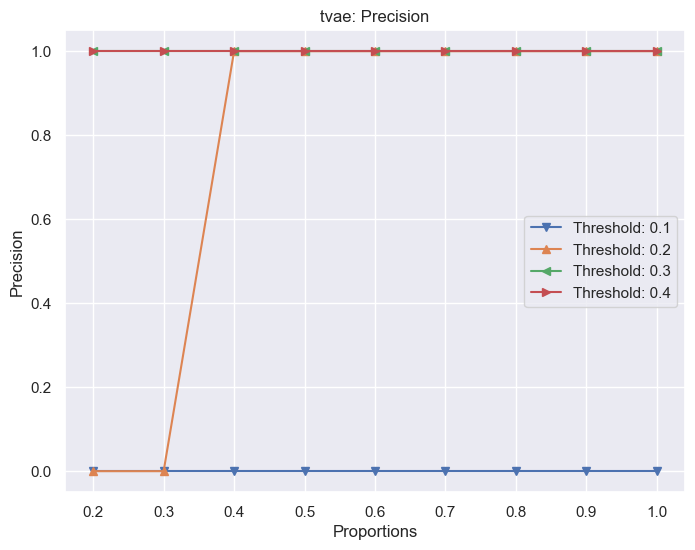

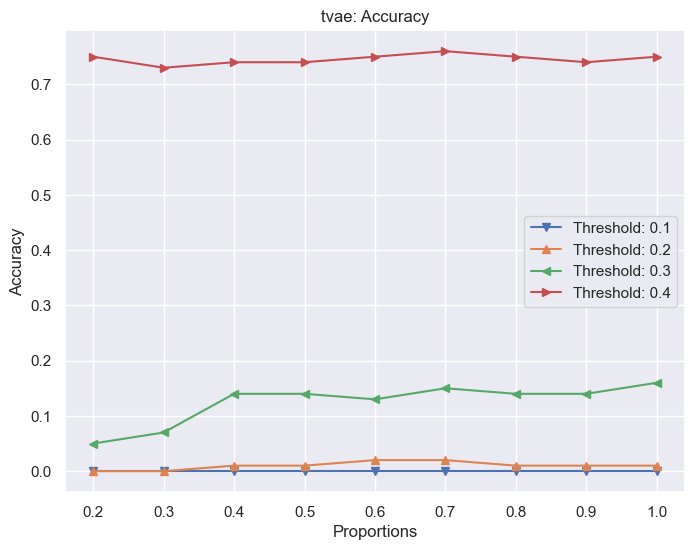

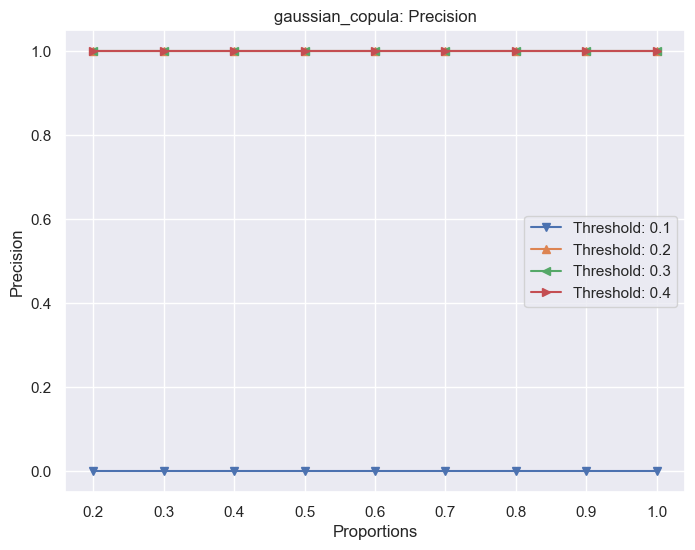

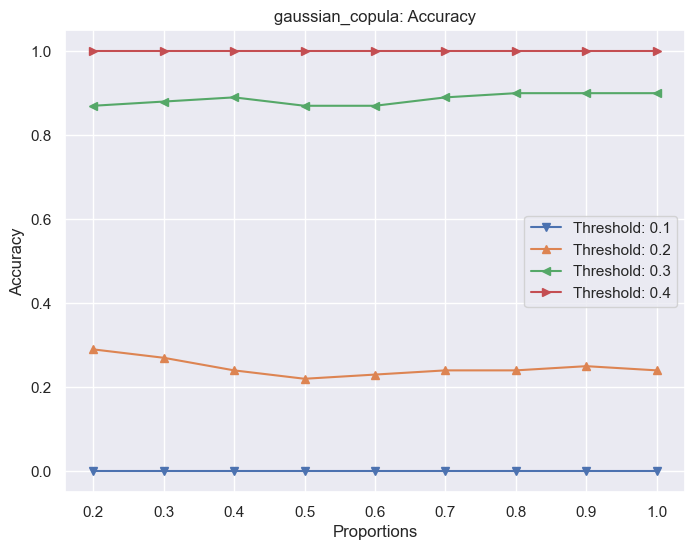

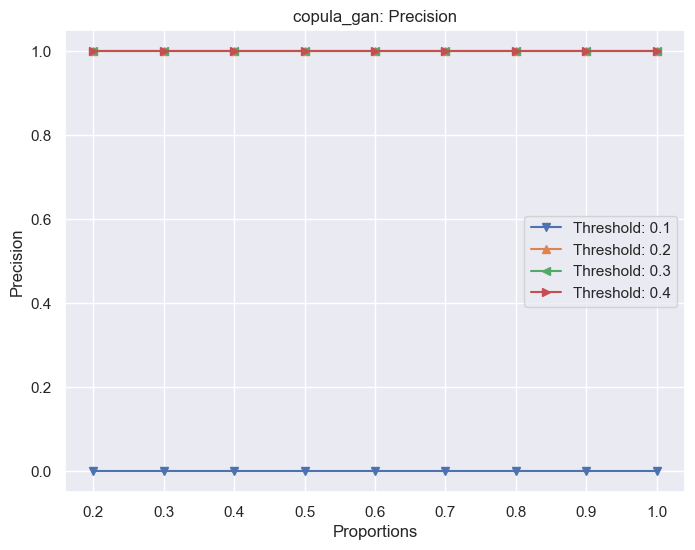

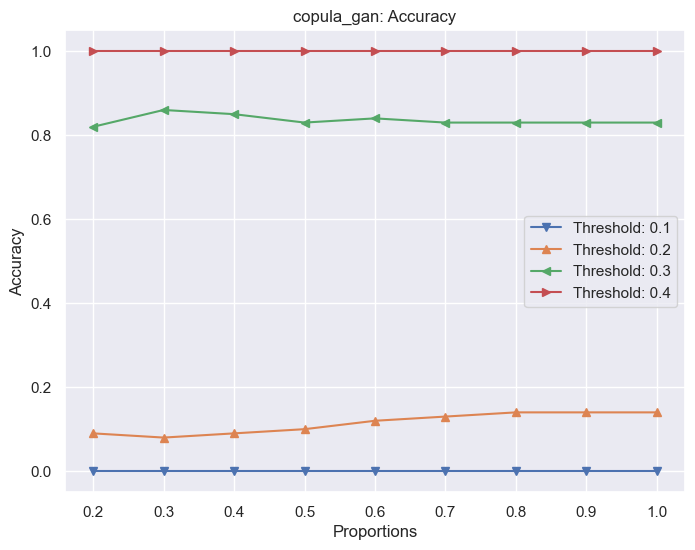

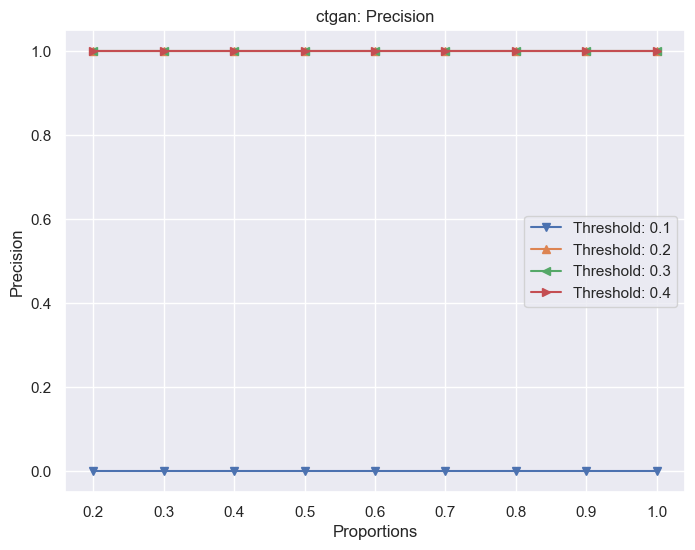

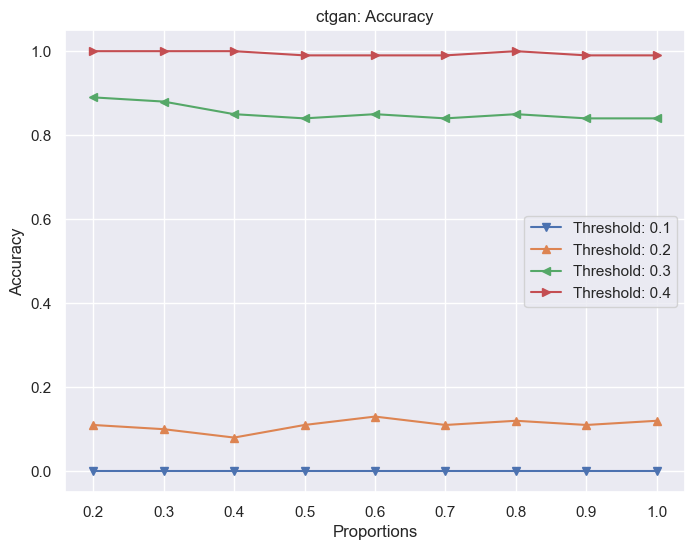

In [22]:
mia_results = {}
for i, model in enumerate(models):
    mia_results[model_names[i]] = mia(train_data, model, model_names[i], dataset_nr=5, save_plts=True)
